In [53]:
import sys
sys.path.insert(0, 'C:/Users/MyPC/Desktop/git/AVATAR_motionMap')
import FileManager.csvload as acl
sys.path.insert(0, 'C:/Users/MyPC/Desktop/git/kp_moseq/keypoint-moseq/project')
import SDSBD_trainset2.params as params

import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import time
from datetime import date
import os
import keypoint_moseq as kpms
import keypoint_moseq .analysis as kpmsa
preSD_defeated = params.preSD_defeated
preSD_extrR = params.preSD_extrR
preSD_extrS = params.preSD_extrS
postSD_extrR = params.postSD_extrR
postSD_extrS = params.postSD_extrS
postSD_defeated = params.postSD_defeated
postSD_control = params.postSD_control

# parameters setting
start = params.start    # analysis start frame of the video
end = params.end        # analysis end frame of the video
syllable_analyzed = params.core_syllable_num
filelist_group1 = acl.get_csv_paths(preSD_defeated)    #[]
#filelist_group2 = acl.get_csv_paths()
#dataset = filelist_group1 + filelist_group2
dataset = filelist_group1
class_two = False
SIT_params = acl.import_SIT_params(r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-SDSBD\AVATAR_SDSBD총정리.xlsx')

if class_two:
    dataset_class = [0]*len(filelist_group1) + [1]*len(filelist_group2)
    if len(dataset) != len(dataset_class):
        print('Error: dataset and dataset_class should have the same length')
        sys.exit()


# read "sylable reindexed" column from each csv file and store it in a dictionary
data_moseq = {}  # Initialize an empty dictionary
for file, group in zip(dataset, dataset_class):
    file_name = os.path.splitext(os.path.basename(file))[0]
    data_moseq[file_name] = {}  # Create a new dictionary for each file with the file as the key
    data_moseq[file_name]['class'] = group  # Store the class of the file in the dictionary
    
    # Read the csv file
    df = pd.read_csv(file)
    df = df[start:end]
    
    # Convert the 'syllables reindexed' column to a numpy array, wrap it in a list, and store it in the dictionary
    data_moseq[file_name]['syllables reindexed'] = [df['syllables reindexed'].to_numpy(dtype=int)]
    frequencies, durations = kpmsa.get_syllable_statistics(data_moseq[file_name]['syllables reindexed'], max_syllable=100, count='frequency')

    # Calculate the relative frequencies
    total_frequency = sum(frequencies.values())
    relative_frequencies = {k: v / total_frequency for k, v in frequencies.items()}

    # Remove syllables that are not in the range of syllables analyzed
    #frequencies = {key: value for key, value in frequencies.items() if key in range(syllable_analyzed)}
    #relative_frequencies = {key: value for key, value in relative_frequencies.items() if key in range(syllable_analyzed)}
    #rations = {key: value for key, value in durations.items() if key in range(syllable_analyzed)}
    
    # Store relative frequencies in the dictionary
    data_moseq[file_name]['syllables frequency'] = frequencies
    data_moseq[file_name]['syllables relative frequency'] = relative_frequencies
    data_moseq[file_name]['syllables durations'] = durations


for key in data_moseq.keys():
    last_three_digits_str = key[-3:]
    
    # 마지막 세 자리가 숫자인지 확인
    if not last_three_digits_str.isdigit():
        raise ValueError(f"Key {key} does not end with three digits")

    # 마지막 세 자리를 정수로 변환
    last_three_digits = int(last_three_digits_str)
    if last_three_digits not in SIT_params:
        raise KeyError(f"No matching key in SIT_params for {last_three_digits}")
    data_moseq[key]['SI ratio'] = SIT_params[last_three_digits]


0-2. Total recording time을 first, second half로 각각 나눠서 syllable 계산.

In [4]:
import sys
sys.path.insert(0, 'C:/Users/MyPC/Desktop/git/AVATAR_motionMap')
import FileManager.csvload as acl
sys.path.insert(0, 'C:/Users/MyPC/Desktop/git/kp_moseq/keypoint-moseq/project')
import SDSBD_trainset2.params as params
from collections import OrderedDict
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import time
from datetime import date
import os
import keypoint_moseq as kpms
import keypoint_moseq .analysis as kpmsa
preSD_defeated = params.preSD_defeated
preSD_extrR = params.preSD_extrR
preSD_extrS = params.preSD_extrS
postSD_extrR = params.postSD_extrR
postSD_extrS = params.postSD_extrS
postSD_defeated = params.postSD_defeated
postSD_control = params.postSD_control

# parameters setting
start = params.start    # analysis start frame of the video
end = params.end        # analysis end frame of the video
middle = round((end - start) / 2)  # middle frame of the video data
syllable_analyzed = params.core_syllable_num
filelist_group1 = acl.get_csv_paths(preSD_defeated)    #[]
#filelist_group2 = acl.get_csv_paths()
#dataset = filelist_group1 + filelist_group2
dataset = filelist_group1
class_two = False   # True if there are two classes in the dataset
SIT_params = acl.import_SIT_params(r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-SDSBD\AVATAR_SDSBD총정리.xlsx')

if class_two:
    dataset_class = [0]*len(filelist_group1) + [1]*len(filelist_group2)
    if len(dataset) != len(dataset_class):
        print('Error: dataset and dataset_class should have the same length')
        sys.exit()
else:
    dataset_class = [0]*len(filelist_group1)


# read "sylable reindexed" column from each csv file and store it in a dictionary
data_moseq = {}  # Initialize an empty dictionary
for file, group in zip(dataset, dataset_class):
    file_name = os.path.splitext(os.path.basename(file))[0]
    data_moseq[file_name] = {}  # Create a new dictionary for each file with the file as the key
    data_moseq[file_name]['class'] = group  # Store the class of the file in the dictionary
    
    # Read the csv file
    df = pd.read_csv(file)
    df = df[start:end]

    data_moseq[file_name]['syllables reindexed'] = [df['syllables reindexed'].to_numpy(dtype=int)]
    values_total = df['syllables reindexed'].to_numpy(dtype=int)
    # 전반, 후반 나눠서 feature processing. (ie. 기존 12000frame*20syllables -> 6000frame*(20syllables*2))

    # 앞의 6000개와 뒤의 6000개로 나누기
    first_half = [values_total[:middle]]
    second_half = [values_total[middle:]]

    # kpmsa.get_syllable_statistics 모듈에 각 부분을 넣고 결과 가져오기
    freq_first_half, dur_first_half = kpmsa.get_syllable_statistics(first_half, max_syllable=100, count='frequency')
    freq_second_half, dur_second_half = kpmsa.get_syllable_statistics(second_half, max_syllable=100, count='frequency')

    # Calculate the relative frequencies
    total_frequency = sum(freq_first_half.values()) + sum(freq_second_half.values())
    relative_freq_first_half = {k: v / total_frequency for k, v in freq_first_half.items()}
    relative_freq_second_half = {k: v / total_frequency for k, v in freq_second_half.items()}

    # Remove syllables that are not in the range of syllables analyzed
    freq_first_half = {key: value for key, value in freq_first_half.items() if key in range(syllable_analyzed)}
    freq_second_half = {key: value for key, value in freq_second_half.items() if key in range(syllable_analyzed)}
    relative_freq_first_half = {key: value for key, value in relative_freq_first_half.items() if key in range(syllable_analyzed)}
    relative_freq_second_half = {key: value for key, value in relative_freq_second_half.items() if key in range(syllable_analyzed)}
    dur_first_half = {key: value for key, value in dur_first_half.items() if key in range(syllable_analyzed)}
    dur_second_half = {key: value for key, value in dur_second_half.items() if key in range(syllable_analyzed)}

    # 두 결과를 가로로 합치기
    frequencies = {}
    relative_frequencies = {}
    durations = {}
    for key in relative_freq_first_half.keys():
        frequencies[str(key) + "_first_half"] = freq_first_half[key]
        frequencies[str(key) + "_second_half"] = freq_second_half[key]
        relative_frequencies[str(key) + "_first_half"] = relative_freq_first_half[key]
        relative_frequencies[str(key) + "_second_half"] = relative_freq_second_half[key]
        durations[str(key) + "_first_half"] = dur_first_half[key]
        durations[str(key) + "_second_half"] = dur_second_half[key]

    # Store relative frequencies in the dictionary
    data_moseq[file_name]['syllables frequency'] = frequencies
    data_moseq[file_name]['syllables relative frequency'] = relative_frequencies
    data_moseq[file_name]['syllables durations'] = durations

for key in data_moseq.keys():
    last_three_digits_str = key[-3:]
    
    # 마지막 세 자리가 숫자인지 확인
    if not last_three_digits_str.isdigit():
        raise ValueError(f"Key {key} does not end with three digits")

    # 마지막 세 자리를 정수로 변환
    last_three_digits = int(last_three_digits_str)
    if last_three_digits not in SIT_params:
        raise KeyError(f"No matching key in SIT_params for {last_three_digits}")
    data_moseq[key]['SI ratio'] = SIT_params[last_three_digits]



In [ ]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# 분석기 초기화
qda = QuadraticDiscriminantAnalysis()

# Repeated Stratified K-Fold 객체 생성
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=200, random_state=42)

# 결과 저장을 위한 리스트
scores = []

# 교차 검증 수행
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    qda.fit(X_train, y_train) # 모델 훈련
    predictions = qda.predict(X_test) # 예측
    score = accuracy_score(y_test, predictions) # 정확도 계산
    scores.append(score)

# 평균 정확도 출력
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


Average accuracy:  0.7090892857142856


In [ ]:
# dictionary 확인
for key, value in data_moseq.items():
    si_ratio = value.get('SI ratio', 'Not found')  # 'SI ratio'가 없으면 'Not found' 반환
    print(f'Key: {key}, SI ratio: {si_ratio}')


이진분류기 데이터 준비

In [20]:
if class_two:
    # Prepare data
    X = []  # Features
    y = []  # Response
    for file_name, data in data_moseq.items():
        relative_frequency_values = list(data['syllables relative frequency'].values())
        X.append(relative_frequency_values)
        response_value = data['class']
        y.append(response_value)

    # Convert to NumPy arrays
    X = np.array(X)
    y = np.array(y)

1-1. QDA (Quadratic Discriminant Analysis) model training

In [122]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# 분석기 초기화
qda = QuadraticDiscriminantAnalysis()

# Repeated Stratified K-Fold 객체 생성
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=200, random_state=42)

# 결과 저장을 위한 리스트
scores = []

# 교차 검증 수행
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    qda.fit(X_train, y_train) # 모델 훈련
    predictions = qda.predict(X_test) # 예측
    score = accuracy_score(y_test, predictions) # 정확도 계산
    scores.append(score)

# 평균 정확도 출력
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


Average accuracy:  0.7090892857142856


syllable 절대값(syllables_reindexed)에 표준화(standardization) 적용 -> QDA    (syllable 상대빈도 말고)

1-1-2. PCA -> QDA

0.68 accuracy with a standard deviation of 0.12


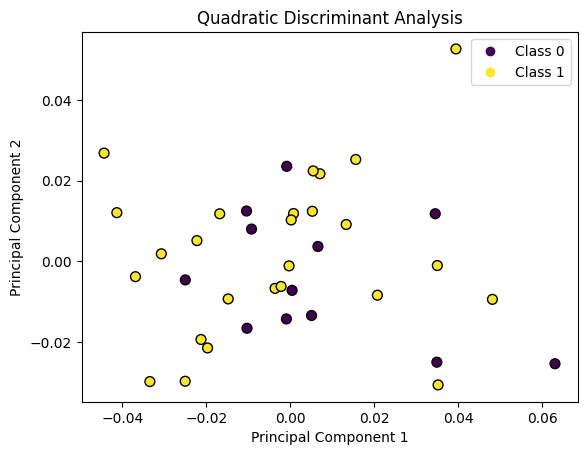

In [120]:
# from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.model_selection import permutation_test_score
# from sklearn.metrics import accuracy_score
# from sklearn.decomposition import PCA

# # Prepare data
# X = []  # Features
# y = []  # Response
# for file_name, data in data_moseq.items():
#     relative_frequency_values = list(data['syllables relative frequency'].values())
#     X.append(relative_frequency_values)
#     response_value = data['class']
#     y.append(response_value)

# # Convert to NumPy arrays
# X = np.array(X)
# y = np.array(y)

# # 주성분 분석으로 데이터 축소
# pca = PCA(n_components=6)
# X_pca = pca.fit_transform(X)

# # 분석기 초기화
# clf_qda = QuadraticDiscriminantAnalysis()

# # Repeated Stratified K-Fold 객체 생성
# cv_rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=200, random_state=42)

# # Cross-validation scores
# scores_cv = cross_val_score(clf_qda, X_pca, y, cv=cv_rskf)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_cv.mean(), scores_cv.std()))
# clf_qda.fit(X_pca, y)

# ## Visualize the QDA classifier
# # Fit PCA with 2 components for visualization
# pca2 = PCA(n_components=2)
# X_pca2 = pca2.fit_transform(X)

# # Decision boundary in the space of the first two principal components
# x_min, x_max = X_pca2[:, 0].min() - 0.5, X_pca2[:, 0].max() + 0.5
# y_min, y_max = X_pca2[:, 1].min() - 0.5, X_pca2[:, 1].max() + 0.5
# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
#                      np.arange(y_min, y_max, 0.1))

# # Transform grid using the same 2D PCA transformation
# grid = np.c_[xx.ravel(), yy.ravel()]
# grid_pca = pca.transform(pca2.inverse_transform(grid))

# # Predict on the 10D transformed grid
# Z = clf_qda.predict(grid_pca)
# Z = Z.reshape(xx.shape)

# # Plot
# # plt.contourf(xx, yy, Z, alpha=0.8)
# scatter = plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=y, edgecolors='k', marker='o', s=50)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Quadratic Discriminant Analysis')
# plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
# plt.show()

1-2. Permutation test

Model score: 0.7090892857142856
Permutation test p-value: 0.04395604395604396


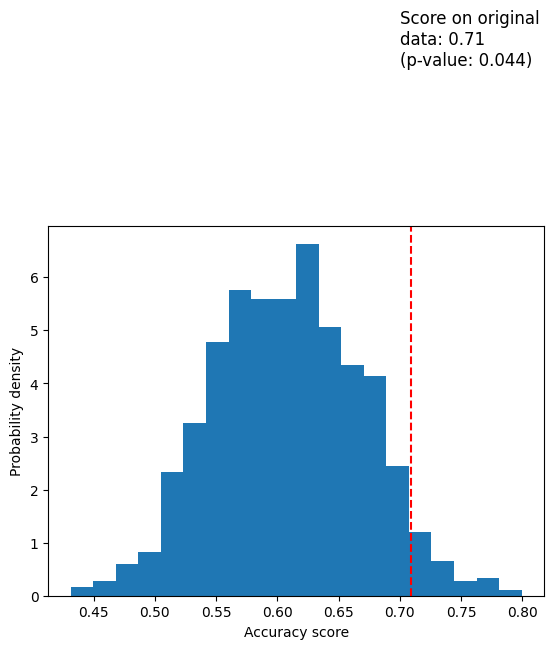

In [124]:
import matplotlib.pyplot as plt
# 분석기 초기화
qda = QuadraticDiscriminantAnalysis()

# 순열 테스트 수행
score, permutation_scores, pvalue = permutation_test_score(qda, X, y, scoring="accuracy", cv=cv, n_permutations=1000, n_jobs=2)

# 결과 출력
print("Model score: %s" % score)
print("Permutation test p-value: %s" % pvalue)

fig, ax = plt.subplots()

ax.hist(permutation_scores, bins=20, density=True)
ax.axvline(score, ls="--", color="r")
score_label = f"Score on original\ndata: {score:.2f}\n(p-value: {pvalue:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability density")

1-3. Confusion matrix

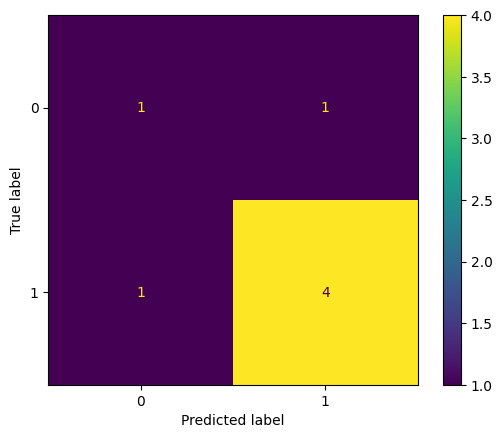

True Positive : 4
True Negative : 1
False Positive : 1
False Negative : 1
Precision score 0.8


In [67]:
from sklearn.metrics import ConfusionMatrixDisplay,precision_score,recall_score,confusion_matrix

ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.show()
 
tn, fp, fn, tp = confusion_matrix(list(y_test), list(predictions), labels=[0, 1]).ravel()
 
print('True Positive :', tp)
print('True Negative :', tn)
print('False Positive :', fp)
print('False Negative :', fn)
print("Precision score", precision_score(y_test,predictions))

2-1. Linear discriminant analysis

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import accuracy_score

# Prepare data
X = []  # Features
y = []  # Response
for file_name, data in data_moseq.items():
    relative_frequency_values = list(data['syllables relative frequency'].values())
    X.append(relative_frequency_values)
    response_value = data['class']
    y.append(response_value)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# 분석기 초기화
lda = LinearDiscriminantAnalysis()

# Repeated Stratified K-Fold 객체 생성
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1000, random_state=42)

# 결과 저장을 위한 리스트
scores = []

# 교차 검증 수행
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lda.fit(X_train, y_train) # 모델 훈련
    predictions = lda.predict(X_test) # 예측
    score = accuracy_score(y_test, predictions) # 정확도 계산
    scores.append(score)

# 평균 정확도 출력
print("Average accuracy: ", np.mean(scores))

# 분석기 초기화
lda = LinearDiscriminantAnalysis()

# 순열 테스트 수행
score, permutation_scores, pvalue = permutation_test_score(lda, X, y, scoring="accuracy", cv=cv, n_permutations=1000, n_jobs=1)

# 결과 출력
print("Model score: %s" % score)
print("Permutation test p-value: %s" % pvalue)


3-1. 라쏘 회귀 (정규화 선형회귀)

In [28]:
# Prepare data
X = []  # Features
y = []  # Response
for file_name, data in data_moseq.items():
    relative_frequency_values = list(data['syllables relative frequency'].values())
    X.append(relative_frequency_values)
    response_value = data['SI ratio']
    y.append(response_value)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

In [38]:
from sklearn.preprocessing import StandardScaler

# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 라쏘 회귀 모델 정의 (alphas 매개변수를 조정하여 다양한 값 시도)
lasso = LassoCV(cv=5, alphas=np.logspace(-8, 1, 13),  max_iter=100000)  # 알파 범위 조정

# 모델 학습
lasso.fit(X_train_scaled, y_train)

# 특성 중요도
feature_importance = lasso.coef_

In [26]:
dddd = np.logspace(-6, 6, 13)